In [42]:
from clawpack import pyclaw
import numpy  as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML
from __future__ import absolute_import
from clawpack import riemann
#from clawpack.riemann.shallow_roe_with_efix_1D_constants import depth, momentum, num_eqn

In [43]:
def sigmoid(x):
    p = np.multiply(-1,x)
    vals = 1/(1+np.power(np.e,p))
    return vals
#sigmoid([0,1,2])

In [44]:
def entropycalc(hei,velo,num_ghost,t):
    #pass in h-b to adjust for topography
    #ghost = h[:num_ghost] + h[-num_ghost:]
    #ughost = u[:num_ghost] + u[-num_ghost:]#remove BC values
    #print(h)
    hfixed = hei[num_ghost:-num_ghost]
    #newval = np.subtract(hfixed,1)
    #print(hfixed)
    ufixed = velo[num_ghost:-num_ghost] # Removing the ghost cells
    PE = np.multiply(np.multiply(hfixed,np.multiply(ufixed,ufixed) ),0.5)
    KE = np.multiply(hfixed,hfixed)
    currentEntropyArray = np.add(KE, PE) #- hghost - ughost
    summedE = np.sum(currentEntropyArray)/len(hfixed)
    global entropies
    global fullE
    global hss
    global uss
    global dts
    edgeH = [hfixed[0],hfixed[-1]]
    edgeU = [ufixed[0],ufixed[-1]]
    hss.append(np.multiply(edgeH,1))
    uss.append(np.multiply(edgeU,1))
    fullE = fullE + [currentEntropyArray]
    entropies = entropies + [summedE]
    dts = dts + [t]
    del hfixed
    del hei
    del ufixed
    del velo
    #look at two different states and subtract for flux?    
    #fornberg algorithm for finite differences method take coeffs from result. might be in matlab

In [45]:
 def custom_bc(state,dim,t,qbc,num_ghost):
    #print(qbc[0,:].shape)

    #print("que bee c: ", qbc[0,:])
    entropycalc(qbc[0,:],qbc[1,:],num_ghost,t)
    qbc[0,0] = in_height
    qbc[0,1] = in_height
    qbc[0,-1] = in_height-1
    qbc[0,-2] = in_height-1
    
    #qbc[0,:num_ghost] = qbc[]

    qbc[1,0] = in_velocity
    qbc[1,1] = in_velocity
    qbc[1,-1] = qbc[1,-3]
    qbc[1,-2] = qbc[1,-3]
    

In [254]:
def runclaw(in_height,in_velocity,xlower,xupper,num_points,tfinal,slope,num_out):
    claw = pyclaw.Controller()
    claw.tfinal = tfinal
    claw.keep_copy = True
    claw.output_format = None
    claw.num_output_times = num_out
    #rs = riemann.shallow_roe_with_efix_1D
    rs = riemann.shallow_1D_py.shallow_fwave_1d

    num_eqn = 2
    solver = pyclaw.ClawSolver1D(rs)
    solver.order = 2
    solver.num_ghost = 2
    solver.num_waves=2
    solver.num_eqn=2
    #solver.limiters = pyclaw.limiters.tvd.minmod
    #solver.limiters = pyclaw.limiters.tvd.vanleer

    solver.kernel_language = 'Python'

    #solver.all_bcs = pyclaw.BC.periodic
    solver.bc_upper[0] = pyclaw.BC.extrap
    solver.bc_lower[0] = pyclaw.BC.custom
    #solver.bc_upper[0] = pyclaw.BC.custom
    solver.user_bc_lower = custom_bc
    #solver.user_bc_upper = custom_bc
    #print(solver.bc_lower)
    solver.aux_bc_lower[0] = pyclaw.BC.extrap
    solver.aux_bc_upper[0] = pyclaw.BC.extrap


    #solver.all_bcs = pyclaw.BC.periodic

    #xlower = -2.0
    #xupper = 50.0
    mx = num_points
    x = pyclaw.Dimension(xlower,xupper,mx,name='x')
    domain = pyclaw.Domain(x)
    state = pyclaw.State(domain,num_eqn,1)

    state.problem_data['grav'] = 1.0
    state.problem_data['sea_level'] = 0.0
    state.problem_data['dry_tolerance'] = 0.1

    xc = state.grid.x.centers
    x0=0.0


    #state.q[0,:] = hl * (xc <= x0) + hr * (xc > x0) #+ hc*(x0-obj_size < xc)*(xc < x0+obj_size )
    #state.q[0,:] = 3
    state.q[0,:] = in_height# - ((in_height/1.5)*(xc>=x0+10))  #+(1 * (xc<x0)+ (1 - xc/1) * (xc>= x0) * (xc < 1) )
    #state.q[0,:] = 1+np.cos(xc)*(xc>-np.pi/2)*(xc<np.pi/2)/4 #sigmoid(np.multiply(-1,xc))*(xc>x0-2)
    #state.q[0,:] =  in_height + (0.5 * (xc<x0)+ (0.5 - xc/10) * (xc>= x0) * (xc < 5)) -0.5
    state.q[1,:] = in_velocity #+ 0.5*(xc>= x0) - 0.25*(xc>= x0+15)   #ul * (xc <= x0) + ur * (xc > x0)


    #state.aux[0,:] = slope*(xc<x0)
    
    #state.aux[0,:] = 0.5
    state.aux[0, :] = 0.5 * (xc<x0)+ (0.5 - xc*slope) * (xc>= x0) * (xc < 1/slope *0.5) #low slope IC
    
    
    
    
    #state.aux[0, :] = 1.0 * np.exp(-xc**2 / 0.2**2) - 1.0
    #state.aux[0,:] = sigmoid(np.multiply(-1,xc))/4
    #state.aux[0, :] = 1 * (xc<x0)+ (1 - xc/10) * (xc>= x0) * (xc < 10) #higher slope IC
    #state.aux[0,:] = 0.5* (xc<x0)  #step IC
    #state.aux[0,:] = 0

    #state.q[0,:] = hl * (xc <= x0 - obj_size) + hr * (xc > x0+obj_size) + hc*(x0-obj_size < xc)*(xc < x0+obj_size )
    #state.q[1,:] = hl*ul * (xc <= x0) + hr*ur * (xc > x0)

    #plt.plot(xc,state.q[0,:])
    #plt.plot(xc,state.aux[0,:])
    #plt.plot(xc,state.q[1,:])

    claw.solution = pyclaw.Solution(state,domain)
    claw.solver = solver
    claw.run()
    return [claw.frames,xc]

In [255]:
#plt.plot(xc,state.q[0,:])
#plt.plot(xc,state.aux[0,:])
#plt.plot(xc,state.q[1,:])

In [256]:
def shockcalc(entropy,u,h,dts,ih,iu):
    # need to add upper bc info to calc
    eFluxIn = [0]*(len(h)-1)
    eFluxOut = [0]*(len(h)-1)
    #c = 1 #constant to relate mass to height of water #can factor out since it's in all terms
    #entropies[-5:-1]
    #c(1/2 dh/dt u^2 + h u du/dt + 2gh dh/dt)
    integratedE = 0.0
    adjE = entropy
    for ii in range(1,len(hss)):
        #print(ii)
        dhdt = (-h[ii-1][0] + h[ii][0])/(-dts[ii-1]+dts[ii])
        dudt = (-u[ii-1][0] + u[ii][0])/(-dts[ii-1]+dts[ii])

        eFluxIn[ii-1] =  (0.5*dhdt*(u[ii][0])**2 + h[ii][0]*u[ii][0]*dudt + 2*h[ii][0]*dhdt)
        eFluxOut[ii-1] = (0.5*dhdt*(u[ii][-1])**2 + h[ii][-1]*u[ii][-1]*dudt + 2*h[ii][-1]*dhdt)
        if dts[ii-1]==dts[ii]:
            eFluxIn[ii-1] = 0.0
            eFluxOut[ii-1] = 0.0
        efi = np.sum(eFluxIn)
        efo = np.sum(eFluxOut)
        #print(efi+efo, " efi and efo")
        adjE[ii-1] = np.add(adjE[ii-1],(efi+efo) )
        #print(efi, " EFLUX IN")
        #print(efo, " EFLUX OUT")
    for ii in range(1,len(h)-1):
        #integratedE = integratedE + entropies[ii] -(ih-h[ii][0])*(iu-u[ii][0])**2 -(ih-h[ii][0])**2  - entropies[0]
        #integratedE = integratedE + entropies[ii] - eFluxIn[ii] + eFluxOut[ii] -entropies[0]
        integratedE = integratedE + adjE[ii] -entropy[0]
    return integratedE

In [258]:

#in_heights = [0.7,0.8,0.9,1.1,1.3,1.5,1.7,1.9,2.3,3.0]
#slopes = [1/16,1/8,1/4,1/3,1/2,3/4,1,1.5,2,2.5,3,4,5]
#slopes = np.linspace(0.1,5,99)
#in_heights = [0.1,0.2,0.4,0.8,1.6,2.4,3.0]
#slopes = [1/8,1/4,1/2,1,1.5,2]
#velocities = [0.25,0.5,0.75,0.85,1.0,1.1,1.25,1.5,1.75]
in_heights = np.linspace(1.9,2.4,num=26)
velocities = [1.5]
slopes = np.linspace(0.1,5,num=26)
#in_heights = [.7,1.1]
#slopes = [1/16,1/2]
#velocities = [.25,1.0]
allEs = []
for kk in range(len(velocities)):
    print(kk, " kk out of 7")
    for ii in range(len(in_heights)):
        print(ii, " ii out of 51")
        tempE = []
        for jj in range(len(slopes)):
            print(jj, "jj out of 26")
            slope = slopes[jj]
            in_velocity = velocities[kk]
            in_height = in_heights[ii] #+ slopes[jj]
            xlower = -5
            xupper = 7
            num_points=300
            entropies = []
            fullE = []
            hss = []
            uss = []
            dts = []
            tfinal = 65
            solns,xc = runclaw(in_height, in_velocity, xlower, xupper,num_points,tfinal,slope,1)
            tempE.append(shockcalc(entropies,uss,hss,dts,in_height,in_velocity))
        
        allEs = allEs + [tempE]
    print(allEs)
    '''
    for rr in range(len(allEs)):
        #plt.figure(rr)
        #plt.subplot(111)
        plt.title(str("initial height: "+ str(in_heights[rr])+ " and velocity" + str(velocities[kk]) ))
        plt.xlabel("slope")
        plt.ylabel("entropy")
        plt.tight_layout()
        plt.gcf().subplots_adjust(left=0.20)
        plt.plot(slopes,allEs[rr])
        plt.savefig(str(velocities[kk])+'output'+str(rr)+'.png', dpi=400)
        plt.clf()
    '''

0  kk out of 7
0  ii out of 51
0 jj out of 26
2019-05-26 15:44:43,602 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 15:44:43,605 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 15:44:49,969 INFO CLAW: Solution 1 computed for time t=65.000000


/home/max/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/max/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


1 jj out of 26
2019-05-26 15:44:54,757 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 15:44:54,768 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 15:45:01,300 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 15:45:06,276 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                 

2019-05-26 15:47:14,419 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 15:47:20,900 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 15:47:25,964 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 15:47:25,966 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 15:47:32,462 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 15:47:37,542 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

2019-05-26 15:49:45,456 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 15:49:51,721 INFO CLAW: Solution 1 computed for time t=65.000000
1 jj out of 26
2019-05-26 15:49:56,479 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 15:49:56,482 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 15:50:02,965 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 15:50:07,947 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                     

2019-05-26 15:52:15,599 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 15:52:22,107 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 15:52:27,217 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 15:52:27,220 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 15:52:33,717 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 15:52:38,817 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

2019-05-26 15:54:46,924 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 15:54:53,196 INFO CLAW: Solution 1 computed for time t=65.000000
1 jj out of 26
2019-05-26 15:54:57,941 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 15:54:57,944 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 15:55:04,386 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 15:55:09,390 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                     

2019-05-26 15:57:18,168 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 15:57:24,699 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 15:57:29,823 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 15:57:29,826 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 15:57:36,332 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 15:57:41,475 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

2019-05-26 15:59:50,057 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 15:59:56,328 INFO CLAW: Solution 1 computed for time t=65.000000
1 jj out of 26
2019-05-26 16:00:01,087 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 16:00:01,089 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:00:07,544 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 16:00:12,543 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                     

2019-05-26 16:02:20,556 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:02:27,107 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 16:02:32,239 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 16:02:32,242 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:02:38,775 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 16:02:43,898 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

2019-05-26 16:04:52,438 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:04:58,743 INFO CLAW: Solution 1 computed for time t=65.000000
1 jj out of 26
2019-05-26 16:05:03,484 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 16:05:03,487 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:05:09,957 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 16:05:14,966 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                     

2019-05-26 16:07:24,178 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:07:30,724 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 16:07:35,930 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 16:07:35,933 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:07:42,498 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 16:07:47,623 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

2019-05-26 16:09:56,329 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:10:02,617 INFO CLAW: Solution 1 computed for time t=65.000000
1 jj out of 26
2019-05-26 16:10:07,333 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 16:10:07,336 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:10:13,784 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 16:10:18,792 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                     

2019-05-26 16:12:26,943 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:12:33,499 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 16:12:38,631 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 16:12:38,633 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:12:45,169 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 16:12:50,313 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

2019-05-26 16:14:58,980 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:15:05,221 INFO CLAW: Solution 1 computed for time t=65.000000
1 jj out of 26
2019-05-26 16:15:09,896 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 16:15:09,899 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:15:16,307 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 16:15:21,259 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                     

2019-05-26 16:17:30,778 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:17:37,286 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 16:17:42,410 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 16:17:42,420 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:17:50,853 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 16:17:58,860 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

2019-05-26 16:20:36,247 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:20:42,473 INFO CLAW: Solution 1 computed for time t=65.000000
1 jj out of 26
2019-05-26 16:20:47,143 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 16:20:47,148 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:20:53,536 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 16:20:58,476 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                     

2019-05-26 16:23:04,858 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:23:11,367 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 16:23:16,490 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 16:23:16,492 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:23:22,891 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 16:23:27,868 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

2019-05-26 16:25:59,651 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:26:05,854 INFO CLAW: Solution 1 computed for time t=65.000000
1 jj out of 26
2019-05-26 16:26:10,505 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 16:26:10,508 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:26:16,911 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 16:26:21,810 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                     

2019-05-26 16:28:27,753 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:28:34,149 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 16:28:39,088 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 16:28:39,090 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:28:45,509 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 16:28:50,488 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

2019-05-26 16:31:00,908 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:31:07,067 INFO CLAW: Solution 1 computed for time t=65.000000
1 jj out of 26
2019-05-26 16:31:11,690 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 16:31:11,692 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:31:18,028 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 16:31:22,912 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                     

2019-05-26 16:33:27,973 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:33:34,365 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 16:33:39,304 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 16:33:39,307 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:33:45,773 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 16:33:50,780 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

2019-05-26 16:35:55,192 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:36:01,364 INFO CLAW: Solution 1 computed for time t=65.000000
1 jj out of 26
2019-05-26 16:36:05,958 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 16:36:05,961 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:36:12,264 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 16:36:17,097 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                     

2019-05-26 16:38:21,239 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:38:27,644 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 16:38:32,595 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 16:38:32,597 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:38:39,022 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 16:38:44,044 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

2019-05-26 16:40:47,552 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:40:53,688 INFO CLAW: Solution 1 computed for time t=65.000000
1 jj out of 26
2019-05-26 16:40:58,277 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 16:40:58,280 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:41:04,586 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 16:41:09,401 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                     

2019-05-26 16:43:12,774 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:43:19,154 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 16:43:24,130 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 16:43:24,133 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:43:30,408 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 16:43:35,203 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

2019-05-26 16:45:38,401 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:45:44,997 INFO CLAW: Solution 1 computed for time t=65.000000
1 jj out of 26
2019-05-26 16:45:49,658 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 16:45:49,660 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:45:55,958 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 16:46:00,785 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                     

2019-05-26 16:48:03,854 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:48:10,102 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 16:48:14,851 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 16:48:14,853 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:48:21,106 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 16:48:25,916 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

2019-05-26 16:50:27,529 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:50:33,609 INFO CLAW: Solution 1 computed for time t=65.000000
1 jj out of 26
2019-05-26 16:50:38,119 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 16:50:38,121 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:50:44,353 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 16:50:49,110 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                     

2019-05-26 16:52:50,900 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:52:57,153 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 16:53:01,910 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 16:53:01,912 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:53:08,192 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 16:53:12,997 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

2019-05-26 16:55:13,852 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:55:19,898 INFO CLAW: Solution 1 computed for time t=65.000000
1 jj out of 26
2019-05-26 16:55:24,381 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 16:55:24,392 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:55:30,600 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 16:55:35,309 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                     

2019-05-26 16:57:37,580 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:57:43,870 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 16:57:48,675 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 16:57:48,678 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 16:57:54,965 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 16:57:59,784 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

2019-05-26 17:00:00,490 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:00:06,541 INFO CLAW: Solution 1 computed for time t=65.000000
1 jj out of 26
2019-05-26 17:00:10,977 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 17:00:10,979 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:00:17,168 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 17:00:21,832 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                     

2019-05-26 17:02:22,017 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:02:28,288 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 17:02:33,086 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 17:02:33,089 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:02:39,191 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 17:02:43,772 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

2019-05-26 17:04:42,217 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:04:48,225 INFO CLAW: Solution 1 computed for time t=65.000000
1 jj out of 26
2019-05-26 17:04:52,633 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 17:04:52,636 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:04:58,788 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 17:05:03,399 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                     

2019-05-26 17:07:02,637 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:07:08,743 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 17:07:13,299 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 17:07:13,309 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:07:19,434 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 17:07:24,021 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

2019-05-26 17:09:20,383 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:09:26,369 INFO CLAW: Solution 1 computed for time t=65.000000
1 jj out of 26
2019-05-26 17:09:30,758 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 17:09:30,760 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:09:36,866 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 17:09:41,415 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                     

2019-05-26 17:11:39,089 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:11:45,233 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 17:11:49,803 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 17:11:49,805 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:11:55,925 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 17:12:00,530 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

2019-05-26 17:13:55,875 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:14:01,846 INFO CLAW: Solution 1 computed for time t=65.000000
1 jj out of 26
2019-05-26 17:14:06,178 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 17:14:06,181 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:14:12,209 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 17:14:16,688 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                     

2019-05-26 17:16:13,559 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:16:19,662 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 17:16:24,239 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 17:16:24,242 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:16:30,396 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 17:16:35,018 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

2019-05-26 17:18:28,654 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:18:34,552 INFO CLAW: Solution 1 computed for time t=65.000000
1 jj out of 26
2019-05-26 17:18:38,805 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 17:18:38,807 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:18:44,791 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 17:18:49,203 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                     

2019-05-26 17:20:44,402 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:20:50,305 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 17:20:54,597 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 17:20:54,599 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:21:00,485 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 17:21:04,798 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

2019-05-26 17:22:58,851 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:23:04,692 INFO CLAW: Solution 1 computed for time t=65.000000
1 jj out of 26
2019-05-26 17:23:08,870 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 17:23:08,873 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:23:14,804 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 17:23:19,128 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                     

2019-05-26 17:25:11,569 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:25:17,452 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 17:25:21,745 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 17:25:21,748 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:25:27,637 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 17:25:31,951 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

2019-05-26 17:27:21,868 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:27:27,606 INFO CLAW: Solution 1 computed for time t=65.000000
1 jj out of 26
2019-05-26 17:27:31,702 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 17:27:31,708 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:27:37,498 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 17:27:41,660 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                     

2019-05-26 17:29:30,809 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:29:36,459 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 17:29:40,426 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 17:29:40,433 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:29:46,119 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 17:29:50,086 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

2019-05-26 17:31:36,926 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:31:42,444 INFO CLAW: Solution 1 computed for time t=65.000000
1 jj out of 26
2019-05-26 17:31:46,319 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 17:31:46,321 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:31:51,870 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 17:31:55,738 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                     

2019-05-26 17:33:39,377 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:33:44,976 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 17:33:48,844 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 17:33:48,847 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:33:54,395 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 17:33:58,242 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

2019-05-26 17:35:41,740 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:35:47,284 INFO CLAW: Solution 1 computed for time t=65.000000
1 jj out of 26
2019-05-26 17:35:51,056 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 17:35:51,058 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:35:56,569 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 17:36:00,346 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                     

2019-05-26 17:37:42,715 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:37:48,288 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 17:37:52,077 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 17:37:52,080 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:37:57,598 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 17:38:01,424 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

2019-05-26 17:39:43,683 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:39:49,144 INFO CLAW: Solution 1 computed for time t=65.000000
1 jj out of 26
2019-05-26 17:39:52,877 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 17:39:52,880 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:39:58,351 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 17:40:02,127 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                     

2019-05-26 17:41:43,631 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:41:49,105 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 17:41:52,865 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 17:41:52,868 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:41:58,354 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 17:42:02,117 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

2019-05-26 17:43:43,553 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:43:49,010 INFO CLAW: Solution 1 computed for time t=65.000000
1 jj out of 26
2019-05-26 17:43:52,727 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 17:43:52,730 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:43:58,193 INFO CLAW: Solution 1 computed for time t=65.000000
2 jj out of 26
2019-05-26 17:44:01,975 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                     

2019-05-26 17:45:42,859 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:45:48,355 INFO CLAW: Solution 1 computed for time t=65.000000
14 jj out of 26
2019-05-26 17:45:52,084 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-26 17:45:52,087 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-26 17:45:57,544 INFO CLAW: Solution 1 computed for time t=65.000000
15 jj out of 26
2019-05-26 17:46:01,295 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                   

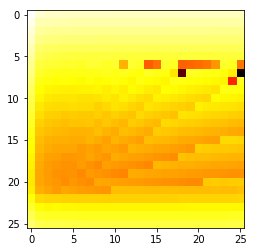

In [261]:
len(allEs[0])
plt.imshow(allEs, cmap = 'hot', interpolation='nearest')
plt.show()
#plt.figure(1)
#plt.subplot(111)
#plt.plot(slopes,allEs[0])
#plt.figure(2)
#plt.subplot(111)
#plt.plot(slopes,allEs[1])

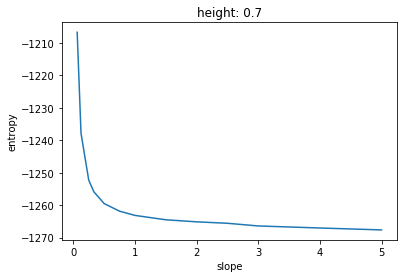

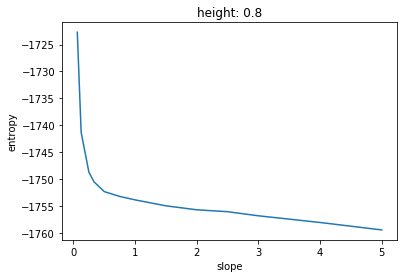

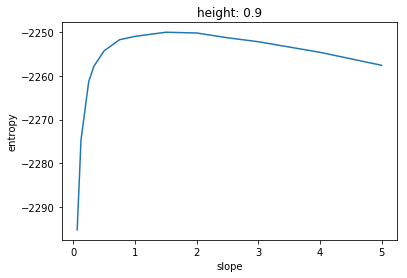

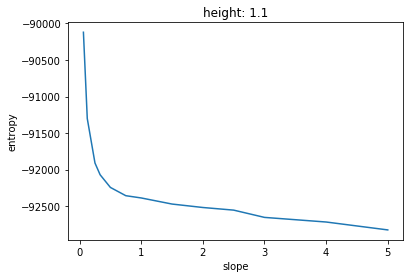

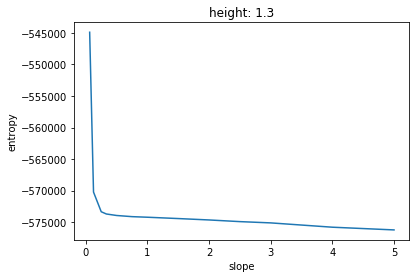

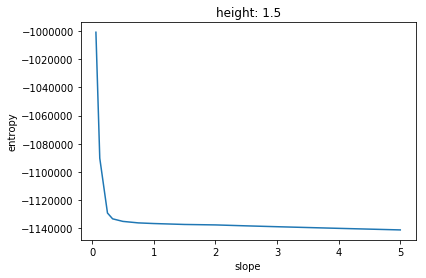

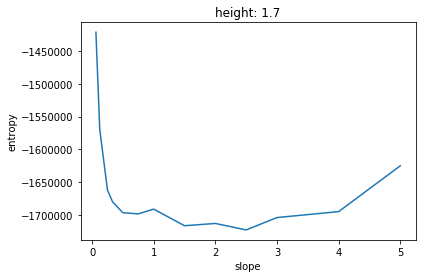

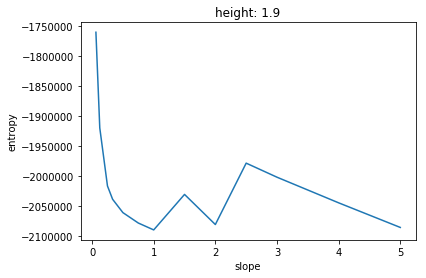

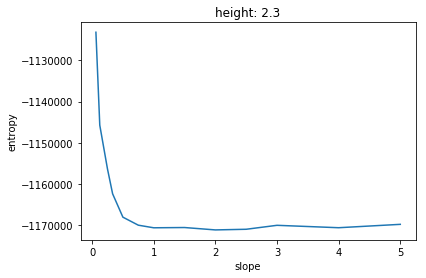

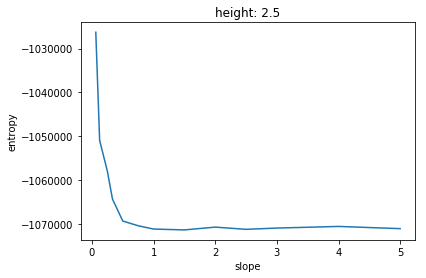

In [17]:
for ii in range(len(allEs)):
    plt.figure(ii)
    plt.subplot(111)
    plt.title(str("initial height: "+ str(in_heights[ii])+ " and velocity" + str(velocities[ii]) ))
    plt.xlabel("slope")
    plt.ylabel("entropy")
    plt.plot(slopes,allEs[ii])
    plt.savefig(str(velocity)+'output'+str(ii)+'.png', dpi=400)

In [247]:
slope = 0.1 #slopes[10]
in_velocity = 1.5
in_height = 2.0 #in_heights[7]
#print(in_height)
xlower = -5
xupper = 8
num_points=500
entropies = []
fullE = []
hss = []
uss = []
dts = []
tfinal = 100
tcount = 100
solns,xc = runclaw(in_height, in_velocity, xlower, xupper,num_points,tfinal,slope,tcount)

2019-05-25 22:39:30,233 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-05-25 22:39:30,236 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-25 22:39:30,382 INFO CLAW: Solution 1 computed for time t=1.000000
2019-05-25 22:39:30,528 INFO CLAW: Solution 2 computed for time t=2.000000
2019-05-25 22:39:30,673 INFO CLAW: Solution 3 computed for time t=3.000000
2019-05-25 22:39:30,823 INFO CLAW: Solution 4 computed for time t=4.000000
2019-05-25 22:39:30,968 INFO CLAW: Solution 5 computed for time t=5.000000
2019-05-25 22:39:31,118 INFO CLAW: Solution 6 computed for time 

101
100


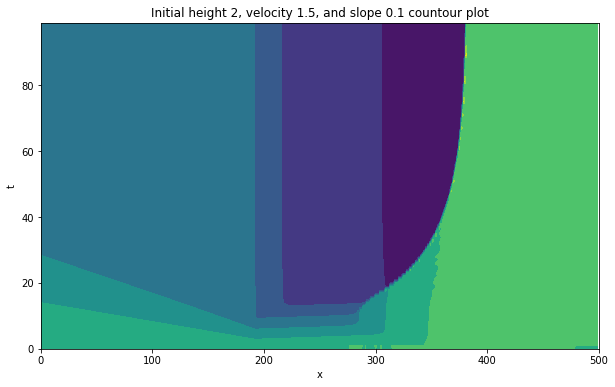

In [251]:
frame = solns[-1]
depth = frame.q[0,:]
depths = []
for ii in range(tcount):
    depths = depths + [solns[ii].q[0,:]]
#print(depths[25])
t = np.linspace(0,50,tcount+1)
print(len(t))
print(len(depths))
plt.figure(figsize=(10,6))
plt.xlim(0,num_points)
plt.xlabel("x")
plt.ylabel("t")
plt.title("Initial height 2, velocity 1.5, and slope 0.1 countour plot")
plt.contourf(depths)

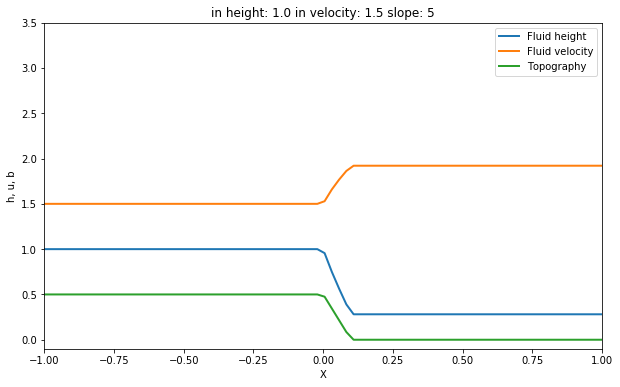

In [246]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes()

#frame = solns[0]
#depth = frame.q[0,:]
line1, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)
line3, = ax.plot([], [], lw=2)
plttitle = "in height: "+ str(in_height) + " in velocity: " + str(in_velocity) + " slope: " + str(slope)
plt.title(plttitle)
plt.legend(['Fluid height','Fluid velocity', 'Topography'])
plt.xlabel('X')
plt.ylabel('h, u, b')
ax.set_xlim(-1,1)
#ax.set_xlim(-1,2)
ax.set_ylim(-0.1,3.5)
frame_number = -1
frame = solns[frame_number]
topo = frame.aux[0,:]-0.5
depth = np.add(frame.q[0,:], topo )
velocity = np.divide( frame.q[1,:], frame.q[0,:] )
b = frame.aux[0,:]
line1.set_data(xc,depth)
line2.set_data(xc,velocity)
line3.set_data(xc,b)
#plt.savefig('fixed_plots//clean_shock', dpi=600)

In [241]:
#in_height = 1.75
#in_velocity = 2
#solns = runclaw(in_height, in_velocity)
fig = plt.figure(figsize=(10,6))
ax = plt.axes()
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=4000)
frame = solns[0]
depth = frame.q[0,:]
line1, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)
line3, = ax.plot([], [], lw=2)
plt.legend(['Fluid height','Fluid velocity', 'Topography'])
plt.xlabel('X')
plt.ylabel('h, u, b')
ax.set_xlim(xlower,xupper)
#ax.set_xlim(-4,4)
ax.set_ylim(-0.1,3.5)
topo = frame.aux[0,:]-0.5
def fplot(frame_number):
    frame = solns[frame_number]
    depth = np.add(frame.q[0,:], topo )
    velocity = np.divide( frame.q[1,:], frame.q[0,:] )
    b = frame.aux[0,:]
    line1.set_data(xc,depth)
    line2.set_data(xc,velocity)
    line3.set_data(xc,b)
    return line1,

anim = animation.FuncAnimation(fig, fplot, frames=len(solns), interval=50, repeat=False) #len(claw.frames) can be put in frames=
#anim.save('rarefaction.mp4',writer=writer)
plt.close()
HTML(anim.to_jshtml())

In [57]:
#test = solns[15]
#test.q[0,:]

def shockcalc(entropy,u,h,dts,ih,iu):
    eFluxIn = [None]*(len(h)-1)
    eFluxOut = [None]*(len(h)-1)
    #c = 1 #constant to relate mass to height of water #can factor out since it's in all terms
    #entropies[-5:-1]
    #c(1/2 dh/dt u^2 + h u du/dt + 2gh dh/dt)
    integratedE = 0.0
    for ii in range(1,len(hss)):
        #print(ii)
        dhdt = (h[ii-1][0] -h[ii][0])/(dts[ii-1]-dts[ii])
        dudt = (u[ii-1][0] -u[ii][0])/(dts[ii-1]-dts[ii])

        eFluxIn[ii-1] =  (0.5*dhdt*(u[ii][0])**2 + h[ii][0]*u[ii][0]*dudt + 2*h[ii][0]*dhdt)
        eFluxOut[ii-1] = (0.5*dhdt*(u[ii][-1])**2 + h[ii][-1]*u[ii][-1]*dudt + 2*h[ii][-1]*dhdt)

        if dts[ii-1]==dts[ii]:
            eFluxIn[ii-1] = 0.0
            eFluxOut[ii-1] = 0.0
    for ii in range(1,len(h)-1):
        integratedE = integratedE + entropies[ii] - (ih-h[ii][0]) - (iu-u[ii][0]) - entropies[0]
        #integratedE = integratedE + entropies[ii] - eFluxIn[ii] + eFluxOut[ii] -entropies[0]
    return integratedE

In [84]:
h[1][0]
#print(np.max(eFluxOut))
#print(np.max(eFluxIn))
#filter(lambda v: v==v, eFluxOut)
#eFluxOut = eFluxOut[np.logical_not(np.isnan(eFluxOut))]
#eFluxOut = eFluxOut[~np.isnan(eFluxOut)]

1.5

In [85]:
#eFluxIn = [None]*(len(h)-1)
#dhdt = (h[ii-1][0] -h[ii][0])/(dts[0]-dts[1])
#dudt = (u[ii-1][0] -u[ii][0])/(dts[0]-dts[1])
#print(dudt)
#eFluxIn[0] = (0.5*dhdt*(u[ii][0])**2 + h[ii][0]*u[ii][0]*dudt + 2*h[ii][0]*dhdt)

In [86]:
print(integratedE)

-127.832393429


In [82]:
print(entropies[-2] - eFluxIn[-2] - eFluxOut[-2] -entropies[0])

0.0209496783448


In [75]:
np.sum(np.subtract(h,1.5))

-1112.2896952423175

In [76]:
np.sum(np.subtract(u,1))

1158.5384300680125

In [77]:
np.sum(u)

11116.538430068013

In [142]:
p1 = [2.3,2.3,2.3,2.3,2.3]
p2 = [4,4.5,5,5.5,6]


p1 = p1 + [2.1,2.0,2.02,1.97,2.05,2.15,2.3,2.31,2.35,1.97,2,2.02,2.2,2.31]
p2 = p2 + [6,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,1,1,1,1,1]


p1 = p1 + [1.97,2,2.02,2.07,2.31,2.06]
p2 = p2 + [4,4,4,4,4,4]

p1 = p1 + [1.97,2,2.31,2.07]
p2 = p2 + [6,6,6,6]
print(len(p1))
print(len(p2))

29
29


Text(0,0.5,'Initial height')

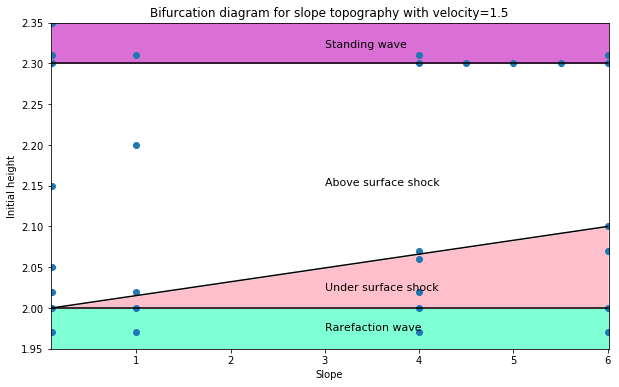

In [145]:
x = [0.1,6]
y1 = [2,2]
y2 = [2,2.1]
y3 = [2.3,2.3]

fig = plt.figure(figsize=(10,6))
ax = plt.axes()
ax.plot(x,y1,color='black')
ax.plot(x,y2,color='black')
ax.plot(x,y3,color='black')
ax.fill_between(x, 0, y1,color='aquamarine')
ax.fill_between(x, y1, y2,color='pink')
ax.fill_between(x, y2, y3,color='w')
ax.fill_between(x, y3, 2.35,color='orchid')
ax.set_xlim(0.09,6.01)
ax.set_ylim(1.95,2.35)
ax.scatter(p2,p1)
ax.text(3,2.022,'Under surface shock',fontsize=11)
ax.text(3,2.15, 'Above surface shock',fontsize=11)
ax.text(3,2.32,'Standing wave',fontsize=11)
ax.text(3,1.972,'Rarefaction wave',fontsize=11)
plt.title('Bifurcation diagram for slope topography with velocity=1.5',fontsize=12)
plt.xlabel('Slope')
plt.ylabel('Initial height')

In [81]:
p1 = [1.6,1.6,1.6,1.6,1.6,3.0,2.4,2.0,1.8,1.7,0.5,1.0,0.75,0.85,0.92,0.9,0.85,0.85,0.85,0.6]
p2 = [.75,1.5,1.2,1.0,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.3,1.2,1.15,1.0]

p1 = p1 + [0.5,0.5,0.5,0.5,.5,0.5,1.0,1.0,1.6,1.6,1.2,0.85,1.0,1.1,1.1,1.1,1.1,1.1,1.1,1.3,1.3,1.3,1.5,1.8,1.8]
p2 = p2 +[1.2,1.8,1.4,1.6,1.7,1.75,0.75,1.0,0.5,0.1,0.1,0.1,0.1,0.1,0.5,0.85,0.7,0.6,0.65,0.6,0.85,1.0,1.0,2.0,0.8]

p1 = p1+ [1.1,1.3,1.2,1.2,1.2,1.2]
p2 = p2 +[0.6,0.6,0.6,0.5,0.3,0.1]


Text(0,0.5,'Initial height')

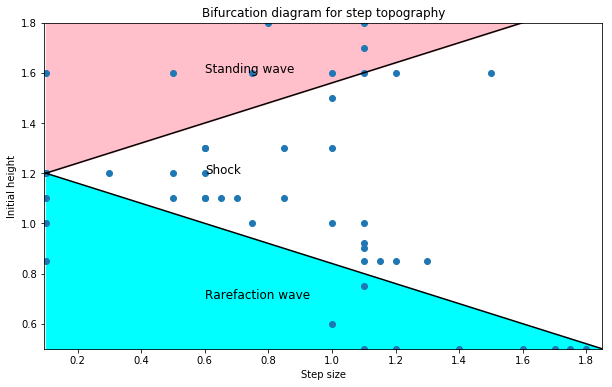

In [98]:
x = [0.1,1.6]
y1 = [1.2,1.8]

x2 = [1.85,0.1]
y2 = [0.5,1.2]

fig = plt.figure(figsize=(10,6))
ax = plt.axes()
ax.plot(x,y1,color="black")
ax.plot(x2,y2,color="black")
#ax.fill_between(x, 0, y1)
#ax.fill_between(x, y1, y2)
#ax.fill_between(x, y2, y3)
#ax.fill_between(x, y3, 2.35)
ax.fill_between(x,y1,1.8,color='pink')
ax.fill_between(x2,0,y2,color='aqua')
#ax.fill_between([0.1,1.8],y2)
ax.scatter(p2,p1)
ax.set_xlim(0.095,1.85)
ax.set_ylim(0.5,1.8)
ax.text(0.6,1.6,'Standing wave',fontsize=12)
ax.text(0.6,1.2, 'Shock',fontsize=12)
ax.text(0.6,0.7,'Rarefaction wave',fontsize=12)
#ax.text(3,1.972,'waaaa',fontsize=12)
plt.title('Bifurcation diagram for step topography')
plt.xlabel('Step size')
plt.ylabel('Initial height')

In [ ]:
x = [1/16,1/8,1/4,1/3,1/2,3/4,1,1.5,2,4,6]
y = [-2000000]

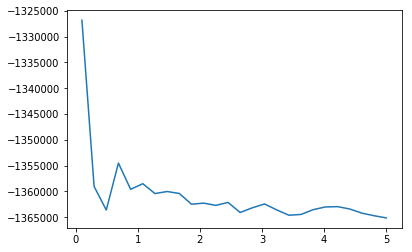

In [153]:
x = np.linspace(0.1,5,num=26)
#data = [-3903100.0921721673, -4112142.7006329917, -4229452.0207258621, -4295179.5091253296, -4336402.3522054059, -4371759.9078396372, -4395929.227069553, -4410539.1576945437, -4414537.5259743184, -4441618.7343026521, -4434577.5577634666, -4457629.5685896454, -4432817.83773774, -4453574.4148515901, -4471398.8672098434, -4483712.2357375417, -4440833.3248190843, -4458327.5400865665, -4473934.8914189562, -4489018.5167365773, -4499484.718337846, -4418002.5680464571, -4430148.2070949804, -4441396.5305947289, -4452728.0559663223, -4463846.310708479, -4475006.868806771, -4486083.0965710701, -4497082.7466817042, -4507507.6434367802, -4517916.5366010731, -4525824.6444393024, -4379875.8033969821, -4386911.725428097, -4393922.8664798317, -4400091.4806818888, -4407086.6719240798, -4413195.2015945539, -4419962.6138976933, -4426142.900165488, -4432902.664562868, -4438825.055112239, -4444853.3454278391, -4450868.8776507732, -4457533.2096148478, -4463437.2091603633, -4469327.0365260355, -4475261.7083037784, -4481173.7020781031, -4486370.188543818, -4492225.4675240535, -4498083.5175802717, -4503942.587160415, -4509112.3633607812, -4515043.3646175545, -4520270.6433664951, -4526213.14942047, -4531452.3433771953, -4536922.3887475068, -4542453.295627879, -4547757.9074770268, -4552903.6714253509, -4211775.0776735209, -4213842.0270052962, -4215251.0782967983, -4217394.8094144873, -4218799.7494548997, -4220892.5832194285, -4222250.5945507484, -4224282.7059756154, -4225635.1226217095, -4227676.001833396, -4229059.1542058038, -4231133.6572423335, -4232468.0314877657, -4234503.6193972072, -4235821.0833721403, -4237117.0018485347, -4239107.2284780592, -4240386.3874053787, -4242370.26320225, -4243664.4799363799, -4244984.064391057, -4247011.7057841653, -4248341.7101054974, -4250340.2953183353, -4251632.8088446613, -4252905.1627530679, -4254864.3399942219, -4256124.1280779792, -4257385.8444567826, -4259314.8534217654, -4260553.3723390838, -4261822.4949232712, -4263103.1142675383, -4265057.8869660636, -4266310.1525979862, -4267576.4241856858, -4269520.2530934894]
#data = [-2545117.4224583842, -2762894.2590352483, -2784629.3576801466, -2794022.8181006932, -2799376.7034744141, -2802756.4931779546, -2805361.9050310184, -2807312.3897126005, -2808701.6240283293, -2809964.6945488625, -2810748.1689926046, -2811981.4487296515, -2812671.6560768043, -2813318.6779768979, -2814023.6838414101, -2814215.0411643325, -2814869.1753996694, -2815529.7408544249, -2815654.1869526622, -2816282.2626082348, -2816907.782943367, -2817103.5035545928, -2817682.2473322931, -2817794.366090978, -2818404.0349761015, -2818567.2047274709]
data = [-1326843.1665722991, -1359041.5791396881, -1363617.3653866265, -1354523.5487152394, -1359606.0396345276, -1358518.3794990981, -1360428.5469330999, -1360031.9429562627, -1360411.4955325683, -1362487.0590207519, -1362285.055011095, -1362716.8518628599, -1362150.3069836432, -1364098.6780363889, -1363186.8734577338, -1362448.4539724838, -1363591.0507071665, -1364626.709180983, -1364474.6521990802, -1363547.4293998494, -1363024.4341246977, -1362963.0867501192, -1363423.8668022985, -1364226.8867378377, -1364725.4104505791, -1365148.2821694755]

plt.plot(x,data)

In [154]:
data2 = np.divide(data, -1*np.min(data))

Text(0.5,1,'Entropy loss for initial height and velocity = [3.0,1.5]')

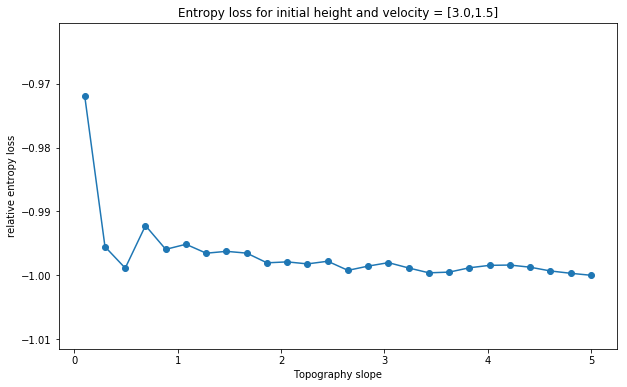

In [155]:
fig = plt.figure(figsize=(10,6))
#ax = plt.axes()
plt.xlabel('Topography slope')
plt.scatter(x,data2)
plt.plot(x,data2)
plt.ylabel('relative entropy loss')
plt.title('Entropy loss for initial height and velocity = [3.0,1.5]')

In [268]:
mya = []
test = np.divide(allEs[0], -1*np.min(allEs[0]))
mya = mya + [test]
print(mya[0])

[-0.89045245 -0.97541299 -0.98496456 -0.98888655 -0.9909829  -0.99255977
 -0.99346698 -0.99425242 -0.9950363  -0.99552809 -0.99597648 -0.99636294
 -0.99682538 -0.99693101 -0.9972954  -0.99772215 -0.99781004 -0.99822378
 -0.99858612 -0.99870176 -0.99882292 -0.9991508  -0.99924916 -0.99965276
 -0.99975032 -1.        ]


In [269]:
data = []
for ii in range(len(allEs)):
    data = data +  [np.divide(allEs[ii], -1*np.min(allEs[ii]))]
#data = np.divide(data, -1*np.min(allEs))

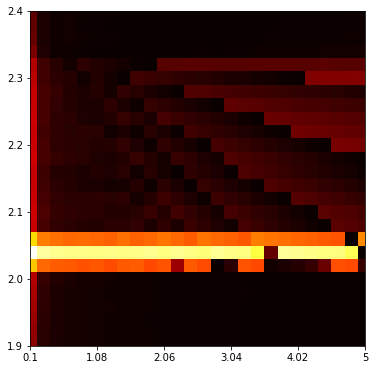

In [328]:
fig = plt.figure(figsize=(6,10))

plt.imshow(data, cmap = 'hot', interpolation='nearest')

a,b = plt.xticks()
#print(a)
#xspacing = 0.196
myxtic = [0,0.1,1.08,2.06,3.04,4.02,5,8]

plt.xticks(a,myxtic)

myytic = [0,1.9,2.0,2.1,2.2,2.3,2.4,8]

plt.yticks(a,myytic)
plt.ylim(0,25)
plt.xlim(0,25)
plt.show()

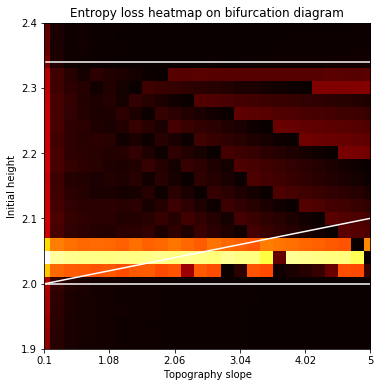

In [362]:
x = [0.1,25]
y1 = [5,5]
y2 = [5,10]
y3 = [22,22]

fig = plt.figure(figsize=(10,6))
ax = plt.axes()
ax.plot(x,y1,color='w')
ax.plot(x,y2,color='w')
ax.plot(x,y3,color='w')
myxtic = [0,0.1,1.08,2.06,3.04,4.02,5,8]

plt.xticks(a,myxtic)

myytic = [0,1.9,2.0,2.1,2.2,2.3,2.4,8]

plt.yticks(a,myytic)
#ax.set_xlim(0.09,6.01)
#ax.set_ylim(1.95,2.35)
plt.imshow(data, cmap = 'hot', interpolation='nearest')
plt.ylim(0,25)
plt.xlim(0,25)
plt.title('Entropy loss heatmap on bifurcation diagram',fontsize=12)
plt.xlabel('Topography slope')
plt.ylabel('Initial height')
plt.show()